In [1]:
# p.45 2.6 確率的勾配降下法
from numpy.random import seed

class AdalineGD(object):
    """ ADAptive LInear NEuron分類器 
    
    パラメータ
    ----------
    eta: float
        学習率 (0.0より大きく1.0以下の値)
    n_iter: int
        トレーニングデータのトレーニング回数
    shuffle: bool (default: True)
        Trueの場合は、循環を回避するためにエポックごとにトレーニングデータをシャッフル
    random_state: int
        重みを初期化するための乱数シード
        
    属性
    ----------
    w_ : 1次元配列
        適合後の重み
    cost_ : list
        各エポックでの誤差平方和のコスト関数
    """
    
    def __init__(self, eta=0.01, n_iter=10, shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        self.random_state = random_state
        
    def fit(self, X, y):
        """ トレーニングデータに適合させる 
        
        パラメータ
        ----------
        X : {入れうtのようなデータ構造}, shape = {n_samples, n_features}
            トレーニングデータ
            n_sampleはサンプルの個数、n_featuresは特徴量の個数
        y : 配列のようなデータ構造, shape = [n_samples]
            目的変数
            
        戻り値
        ----------
        self : object
        """
        
        # 重みベクトルの生成
        self._initialize_weights(X.shape[1])
        
        # コストを格納するリストの生成
        self.cost_ = []
        
        for i in range(self.n_iter): # トレーニング回数分トレーニングデータを反復

            # 指定された場合はトレーニングデータをシャッフル
            if self.shuffle:
                X, y = self._shuffle(X, y)
                
            # 各サンプルのコストを格納するリストの生成
            cost = []

            # 各サンプルに対する計算
            for xi, target in zip(X, y):
                # 特徴量xiと目的変数yを用いた重みの更新とコストの計算
                cost.append(self._update_weights(xi, target))
            
            # サンプルの平均コストの計算
            avg_cost = sum(cost)/len(y)
            
            # 平均コストを格納
            self.cost_.append(avg_cost)
            
        return self
    
    def partial_fit(self, X, y):
        """ 重みを最初期化することなくトレーニングデータに適合させる """
        # 初期化されていない場合は初期化を実行
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
            
        # 目的変数yの要素数が2以上の場合は
        # 各サンプルの特徴量xiと目的変数targetで重みを更新
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        # 目的変数yの要素数が1の場合は
        # サンプル全体の特徴量Xと目的変数yでおおっ身を更新
        else:
            self._update_weights(X, y)
        return self
    
    def _shuffle(self, X, y):
        """ トレーニングデータをシャッフル """
        r = self.rgen.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        """ 重みを小さな乱数に初期化 """
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=1 + m)
        self.w_initialized = True
        
    def _update_weights(self, xi, target):
        """ ADALINEの学習規則を用いて重みを更新 """
        # 活性化関数の出力の計算
        output = self.activation(self.net_input(xi))
        
        # 誤差の計算
        error = (target - output)
        
        # 重み w1, ... wm の更新
        self.w_[1:] += self.eta * xi.dot(error)
        
        # 重み w0 の更新
        self.w_[0] += self.eta * error
        
        # コストの計算
        cost = 0.5 * error**2
        return cost


    def net_input(self, X):
        """ 総入力を計算 """
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def activation(self, X):
        """ 線形活性化関数の出力を計算 """
        return X
    
    def predict(self, X):
        """ 1ステップ後のクラスラベルを返す """
        return np.where(self.activation(self.net_input(X)) >= 0.0, 1, -1)

In [2]:
import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/'
                'machine-learning-databases/iris/iris.data',
                header=None)
print(df.tail())

       0    1    2    3               4
145  6.7  3.0  5.2  2.3  Iris-virginica
146  6.3  2.5  5.0  1.9  Iris-virginica
147  6.5  3.0  5.2  2.0  Iris-virginica
148  6.2  3.4  5.4  2.3  Iris-virginica
149  5.9  3.0  5.1  1.8  Iris-virginica


In [3]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):
    
    # マーカーとカラーマップの準備
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # 決定領域のプロット
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    # グリッドポイントの生成
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                          np.arange(x2_min, x2_max, resolution))

    # 各特徴量を1次元配列に変換して予測を実行
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    
    # 予測結果を元のグリッドポイントのデータサイズに変換
    Z = Z.reshape(xx1.shape)
    
    # グリッドポイントの等高線のプロット
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    
    # 軸の範囲の設定
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    # クラスごとにサンプルをプロット
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                   y=X[y == cl, 1],
                   alpha=0.8,
                   c=colors[idx],
                   label=cl,
                   edgecolor='black')

[]

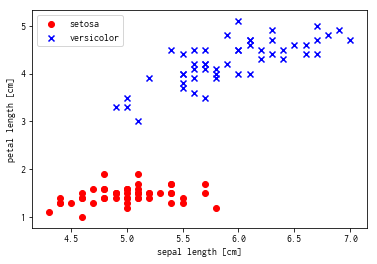

In [4]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# 1-100行目の目的変数の抽出
y = df.iloc[0:100, 4].values

# Iris-setosaを-1, Iris-virginicaを1に変換
y = np.where(y == 'Iris-setosa', -1, 1)

# 1-100行目の1, 3列の抽出
X = df.iloc[0:100, [0, 2]].values

# setosaのプロット(赤の○)
plt.scatter(X[:50, 0], X[:50, 1], color='red', marker='o', label='setosa')

# versicolorのプロット(青の✕)
plt.scatter(X[50:100, 0], X[50:100, 1], color='blue', marker='x', label='versicolor')

# 軸のラベルの設定
plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')

# 凡例の設定(左上に配置)
plt.legend(loc='upper left')

# 図の表示
plt.plot()

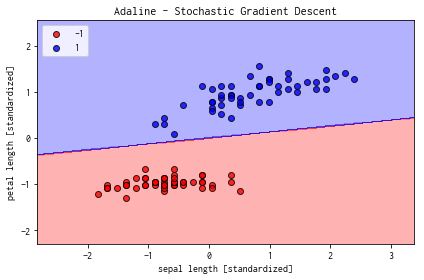

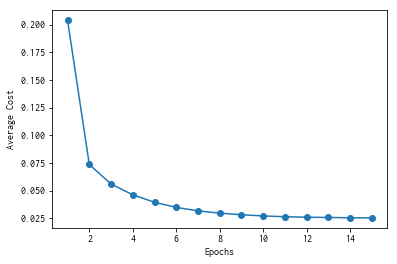

In [5]:
# 確率的勾配降下法によるADALINEの学習

# データのコピー
X_std = np.copy(X)

# 各列の標準化
X_std[:, 0] = (X[:, 0] - X[:, 0].mean()) / X[:, 0].std()
X_std[:, 1] = (X[:, 1] - X[:, 1].mean()) / X[:, 1].std()

ada = AdalineGD(n_iter=15, eta=0.01, random_state=1)

# モデルへの適合
ada.fit(X_std, y)

# 境界領域のプロット
plot_decision_regions(X_std, y, classifier=ada)

# タイトルの設定
plt.title('Adaline - Stochastic Gradient Descent')

# 軸のラベルの設定
plt.xlabel('sepal length [standardized]')
plt.ylabel('petal length [standardized]')

# 凡例の設定(左上に配置)
plt.legend(loc='upper left')
plt.tight_layout()

# プロットの表示
plt.show()

# エポックのコストの折れ線グラフのプロット
plt.plot(range(1, len(ada.cost_)+ 1), ada.cost_, marker='o')

# 軸のラベルの設定
plt.xlabel('Epochs')
plt.ylabel('Average Cost')

# プロットの表示
plt.show()